# Предсказания заказов в такси на следующий час.

# План работ:

- 1.[Подготовка.](#1_Подготовка.)
- 2.[Анализ.](#2_Анализ.)
- 3.[Обучение.](#3_Обучение.)
- 4.[Тестирование.](#4_Тестирование.)
- 5.[Вывод.](#5_Вывод.)

# Описание данных:

- datetime - Дата и время заказа.
- num_orders - Число заказов.

# 1. Подготовка<a id='1_Подготовка.'></a>

In [1]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import numpy as np

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

Загрузим и посмотрим на данные:

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi.index.is_monotonic

True

Порядок даты соблюдён.

In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим пропуски:

In [5]:
taxi.isna().sum()

num_orders    0
dtype: int64

Посмотрим на дубли:

In [6]:
taxi.duplicated().sum()

26415

Подозрительнгое количество дубликатов. Загрузим данные повторно без установки индекса по столбцу, проверим дубли и повторы:

In [7]:
duplic_check = pd.read_csv('/datasets/taxi.csv')

In [8]:
duplic_check.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [9]:
duplic_check.duplicated().sum()

0

In [10]:
del duplic_check

Дублей и пропусков не обнаружено.  

Проверим данные на выбросы:

In [11]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


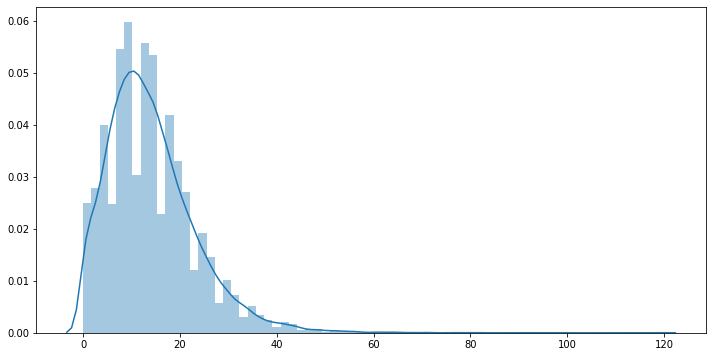

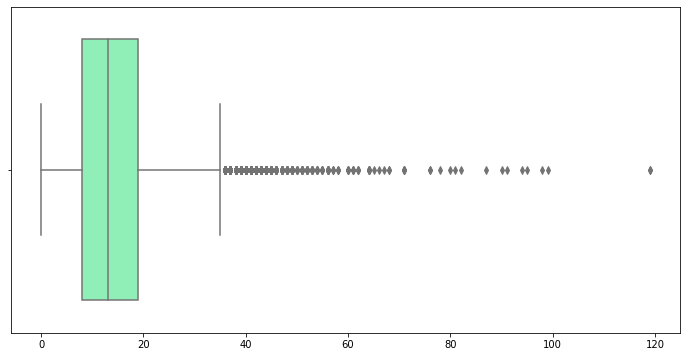

In [12]:
plt.figure(figsize=(12, 6))
sns.distplot(taxi, bins=70)
plt.show()
plt.figure(figsize=(12, 6))
sns.boxplot(taxi, palette='rainbow')
plt.show()

Добавим в выборку признаки часа и дня недели:

In [13]:
def make_datetime(data):
    try:
        data['month'] = data.index.month
    except:
        pass
    try:
        data['hour'] = data.index.hour
    except:
        pass
    try:
        data['dayofweek'] = data.index.dayofweek
    except:
        pass

In [14]:
make_datetime(taxi)
taxi.head(3)

,num_orders,month,hour,dayofweek
datetime,,,,
2018-03-01 00:00:00,9,3,0,3
2018-03-01 00:10:00,14,3,0,3
2018-03-01 00:20:00,28,3,0,3


Видны явные выбросы. Рассмотрим хвосты по боксплоту:

In [16]:
Q1_orders = taxi['num_orders'].quantile(0.25)
Q3_orders = taxi['num_orders'].quantile(0.75)
IQR_orders = Q3_orders - Q1_orders
taxi_emissions = taxi.query('(@Q1_orders - 1.5 * @IQR_orders) <= num_orders >= (@Q3_orders + 1.5 * @IQR_orders)').copy()
taxi_emissions

,num_orders,month,hour,dayofweek
datetime,,,,
2018-03-03 00:40:00,38,3,0,5
2018-03-05 01:00:00,42,3,1,0
2018-03-07 22:10:00,36,3,22,2
2018-03-19 01:50:00,36,3,1,0
2018-03-24 00:50:00,56,3,0,5
...,...,...,...,...
2018-08-31 18:50:00,36,8,18,4
2018-08-31 22:20:00,48,8,22,4
2018-08-31 22:30:00,41,8,22,4


Добавим сюда столбцы часа и дня недели:

In [17]:
taxi_emissions['num_orders'].describe()

count    687.000000
mean      43.822416
std        9.986312
min       36.000000
25%       38.000000
50%       41.000000
75%       46.000000
max      119.000000
Name: num_orders, dtype: float64

Попробуем увидеть закономерность 

In [18]:
for i in range(7):
    count = taxi_emissions[taxi_emissions['dayofweek'] == i]['num_orders'].count()
    print(f'День недели {i}, заказов {count}')

День недели 0, заказов 133
День недели 1, заказов 62
День недели 2, заказов 85
День недели 3, заказов 116
День недели 4, заказов 128
День недели 5, заказов 108
День недели 6, заказов 55


In [19]:
taxi_emissions.groupby(['month', 'dayofweek']).agg({'num_orders': ['count', 'sum']})#.sort_values(by='dayofweek')

num_orders      
                     count   sum
month dayofweek                 
3     0                  4   158
      2                  1    36
      5                  3   131
4     0                  4   155
      1                  3   175
      2                  1    38
      3                  1    39
      4                  2    74
      5                  5   189
5     0                  9   392
      2                  1    39
      3                  7   270
      4                  8   332
      5                 12   502
      6                  4   150
6     0                  5   191
      1                  3   117
      2                  9   373
      3                  1    36
      4                  7   274
      5                  7   281
      6                  4   161
7     0                 28  1161
      1                  9   354
      2                  9   355
      3                 15   639
      4                 18   731
      5                 26  1061
      6                 12   496
8     0                 83  4372
      1                 47  2056
      2                 64  2783
      3                 92  4001
      4                 93  3982
      5                 55  2454
      6                 35  1548

Не наблюдается привязок выбросов к месяцу или дню недели.

In [20]:
taxi_emissions.groupby(['hour']).agg({'num_orders': ['count', 'sum']})#.sort_values(by='dayofweek')

num_orders      
          count   sum
hour                 
0           141  6224
1            69  3086
2           101  4871
3            51  2198
4            41  1930
5             2    91
8             6   264
9            21   860
10           24   997
11            8   308
12            8   305
13            4   151
14            7   282
15           13   533
16           47  1927
17           28  1215
18            6   268
19            2    80
20            4   165
21           19   762
22           31  1268
23           54  2321

И по часам тоже cвязи нет.  

Заменим выбросы на медианы.

In [22]:
for i in list(taxi['dayofweek'].unique()):
    for j in list(taxi['hour'].unique()):
        median = taxi[(taxi['dayofweek'] == i) & (taxi['hour'] == j)]['num_orders'].median()
        index = taxi.loc[(taxi['dayofweek'] == i) & (taxi['hour'] == j) & (taxi['num_orders'] >= (Q3_orders + 1.5 * IQR_orders))]['num_orders'].index
        taxi.loc[index, 'num_orders'] = median

In [23]:
taxi.index.is_monotonic

True

In [24]:
del taxi_emissions
taxi = taxi.drop(['month'], axis=1)

Посмотрим, что получилось:

In [25]:
taxi.describe()

,num_orders,hour,dayofweek
count,26496.000000,26496.000000,26496.000000
mean,13.398060,11.500000,3.005435
std,7.728681,6.922317,1.990497
min,0.000000,0.000000,0.000000
25%,8.000000,5.750000,1.000000
50%,13.000000,11.500000,3.000000
75%,18.000000,17.250000,5.000000
max,35.000000,23.000000,6.000000


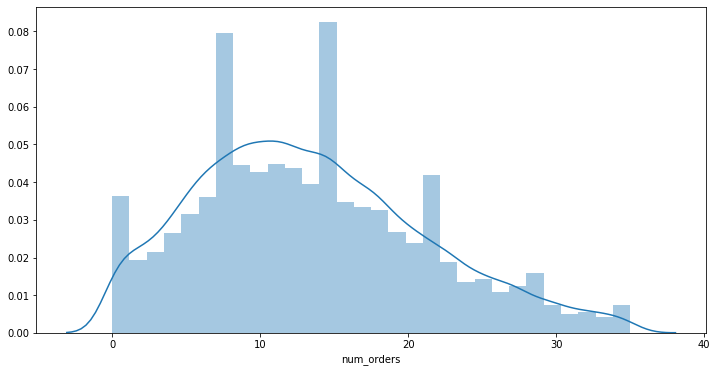

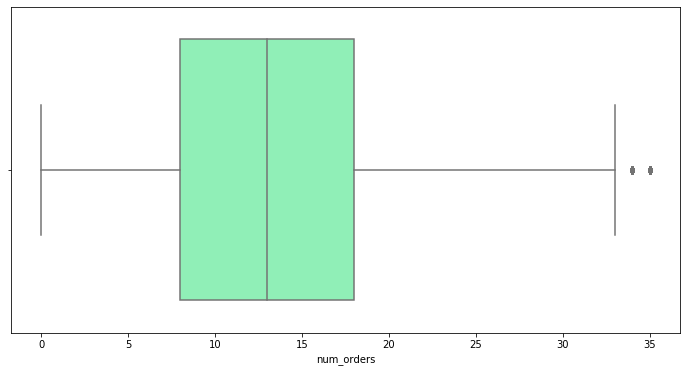

In [26]:
plt.figure(figsize=(12, 6))
sns.distplot(taxi['num_orders'], bins=30)
plt.show()
plt.figure(figsize=(12, 6))
sns.boxplot(taxi['num_orders'], palette='rainbow')
plt.show()

Данные подготовлены, можно двигаться дальше.  

# 2. Анализ.<a id='2_Анализ.'></a>

Посмотрим на график:

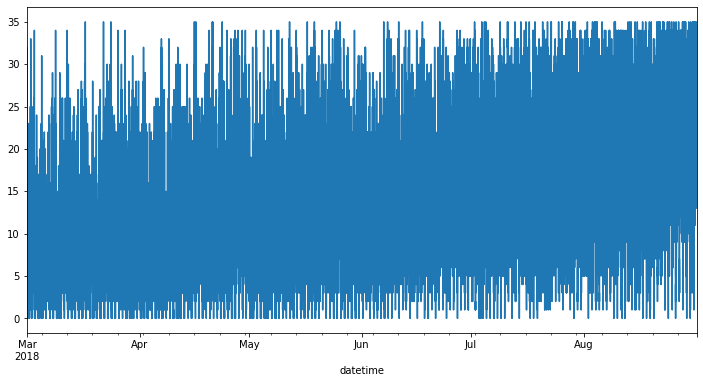

In [27]:
taxi['num_orders'].plot(figsize=(12, 6))

Выводов по этому графику сделать не выходит.  

Сделаем ресемплирование по одному часу:

In [28]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 3 columns):
num_orders    26496 non-null float64
hour          26496 non-null int64
dayofweek     26496 non-null int64
dtypes: float64(1), int64(2)
memory usage: 2.1 MB


In [29]:
taxi = taxi.drop(['dayofweek', 'hour'], axis=1)

In [30]:
taxi = taxi.resample('1H').sum()

In [31]:
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

In [32]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 3 columns):
num_orders    4416 non-null float64
dayofweek     4416 non-null int64
hour          4416 non-null int64
dtypes: float64(1), int64(2)
memory usage: 138.0 KB


In [33]:
display(taxi.head(3))
display(taxi.tail(3))

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124.0,3,0
2018-03-01 01:00:00,85.0,3,1
2018-03-01 02:00:00,71.0,3,2


,num_orders,dayofweek,hour
datetime,,,
2018-08-31 21:00:00,159.0,4,21
2018-08-31 22:00:00,180.0,4,22
2018-08-31 23:00:00,147.0,4,23


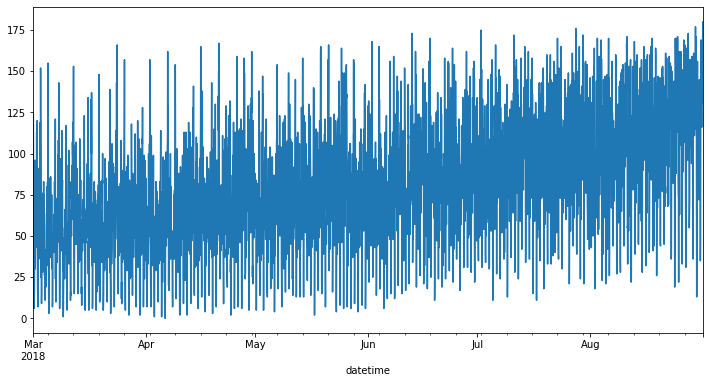

In [34]:
taxi['num_orders'].plot(figsize=(12, 6))

Добавим в выборку признаки часа и дня недели:

Посмотрим на среднее количество заказов по часам:

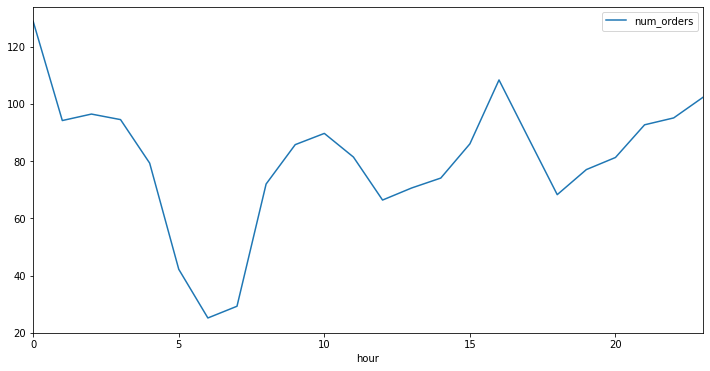

In [37]:
taxi.groupby(['hour']).agg({'num_orders': 'mean'}).plot(figsize=(12, 6))

Видны сильные просадки по заказам примерно с 4 часов утра до 8 часов утра.  

Посмотрим на среднее количество заказов по недели:

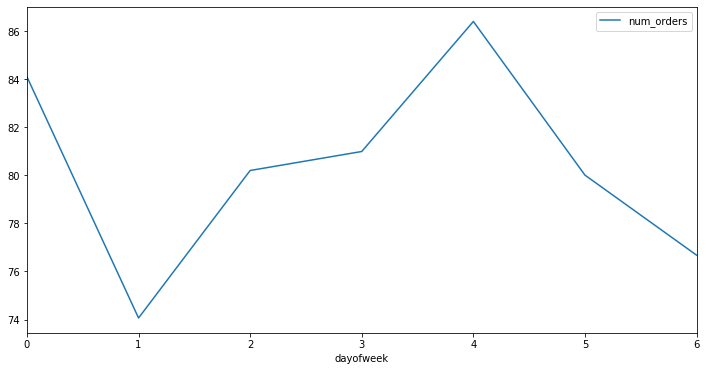

In [38]:
taxi.groupby(['dayofweek']).agg({'num_orders': 'mean'}).plot(figsize=(12, 6))

Очень сильная просадка видна во вторник. В восресенье количество заказов тоже отстаёт.  

Посмотрим на заказы в случайно выбранную неделю со скользящим средним и стандартным отклонением по заказам:

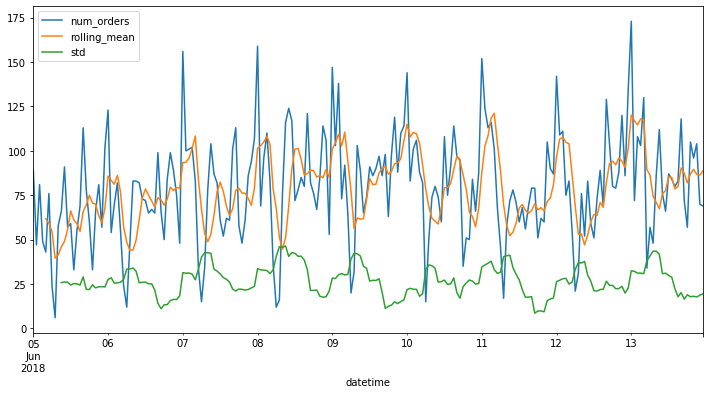

In [39]:
taxi_one_week = taxi['2018-06-05':'2018-06-13'].copy()
taxi_one_week['rolling_mean'] = taxi_one_week['num_orders'].rolling(5).mean()
taxi_one_week['std'] = taxi_one_week['num_orders'].rolling(10).std()
taxi_one_week[['num_orders', 'rolling_mean', 'std']].plot(figsize=(12, 6))

In [40]:
del taxi_one_week

Посмотрим на сезонность этой недели с помощью tsa.seasonal:

In [41]:
decomposed = seasonal_decompose(taxi['num_orders'])

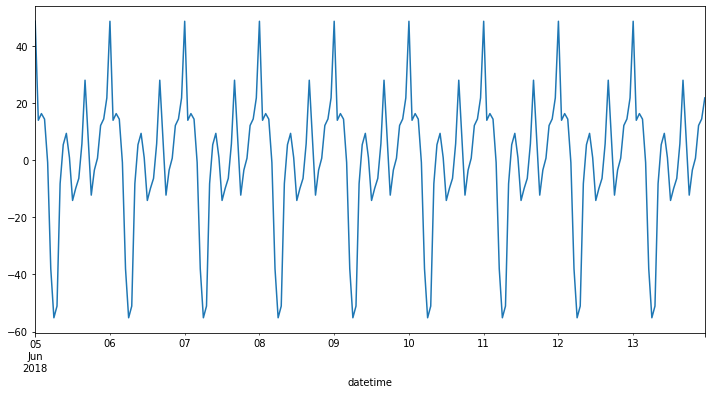

In [42]:
decomposed.seasonal['2018-06-05':'2018-06-13'].plot(figsize=(12, 6))

Цикличность на лицо. с 4 до 8 утра заказов мало.  

Посмотрим на тренд всей выборки: 

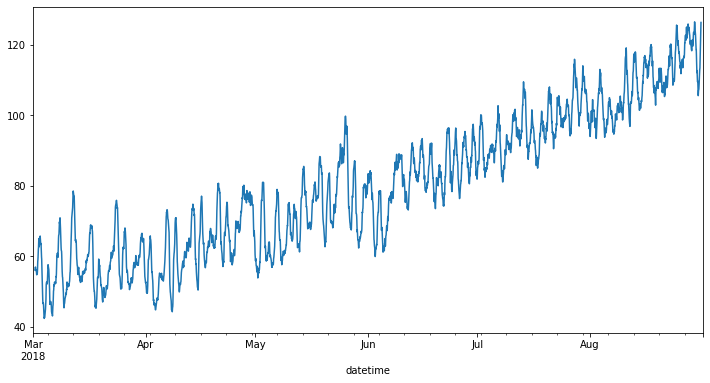

In [43]:
decomposed.trend.plot(figsize=(12, 6))

In [44]:
del decomposed

Виден общий тренд роста по выборке с каждым месяцем. Только в конце сентября резкая просадка. Врекменной ряд не стационарный.

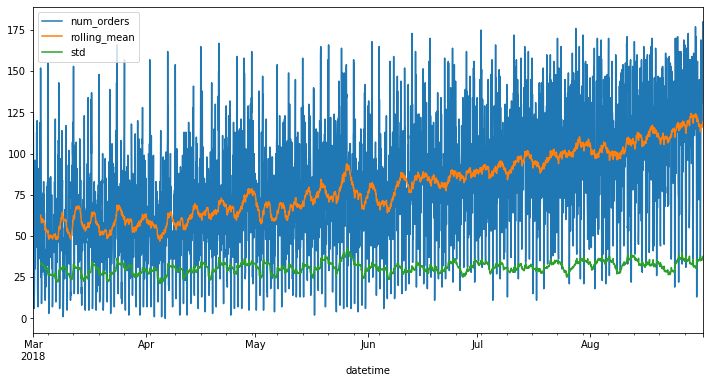

In [45]:
taxi['rolling_mean'] = taxi['num_orders'].rolling(50).mean()
taxi['std'] = taxi['num_orders'].rolling(50).std()
taxi[['num_orders', 'rolling_mean', 'std']].plot(figsize=(12, 6))

In [46]:
taxi = taxi.drop(['rolling_mean', 'std'], axis=1)

In [47]:
taxi.head(3)

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124.0,3,0
2018-03-01 01:00:00,85.0,3,1
2018-03-01 02:00:00,71.0,3,2


Посмотрим, поможет ли сделать его стационарным разность:

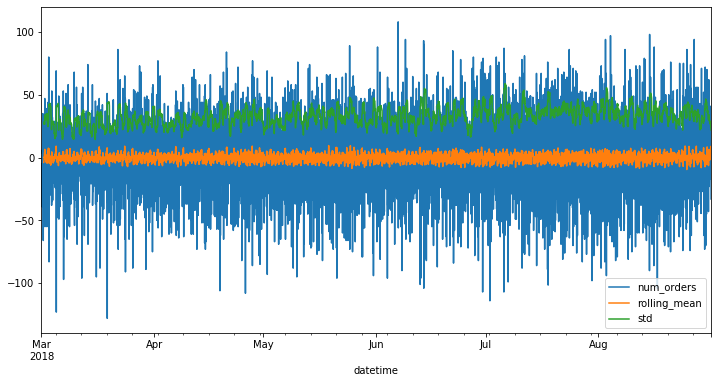

In [48]:
taxi_difference = taxi - taxi.shift()
taxi_difference['rolling_mean'] = taxi_difference['num_orders'].rolling(15).mean()
taxi_difference['std'] = taxi_difference['num_orders'].rolling(15).std()
taxi_difference[['num_orders', 'rolling_mean', 'std']].plot(figsize=(12, 6))

In [49]:
del taxi_difference

Ряд стал намного более стационарным.

# 3. Обучение.<a id='3_Обучение.'></a>

Напишем функцию для создания признаков временных сдвигов и скользящего среднего:

In [50]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Напишем функцию для подбора параметров:

In [51]:
def my_gs_cv(taxi, max_lag, rolling_mean_size, model, max_depth, n_estimators):
    list_score = []
    dict_score = {}
    for lag in range(1, max_lag + 1):  # Перебор лагов
        for rol in range(7, rolling_mean_size + 1):  # Перебор временных окон среднего скользящего
            make_features(taxi, lag, rol)  # Вызов функции добавления признаков
            
            train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
            
            train = train.dropna()
            features_train = train.drop(['num_orders'], axis=1)
            target_train = train['num_orders']
            features_test = test.drop(['num_orders'], axis=1)
            target_test = test['num_orders']
            
            for i in range(1, lag + 1):  # Сброс временных лагов для следующей итерации параметров
                taxi = taxi.drop([f'lag_{i}'], axis=1)
            
            params = {'max_depth':[i for i in range(7, (max_depth + 1), 3)], 'n_estimators':[i for i in range(75, (n_estimators + 1), 25)]}
            gs_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5, iid=False)
            gs_model.fit(features_train, target_train)
            best_params = gs_model.best_params_
            score_gs = (np.abs(gs_model.best_score_)) ** 0.5
            
            list_score.append(score_gs)
            dict_score[score_gs] = f'Самые лучшие параметры модели = {str(best_params)}\nпри количестве времсенных сдвигов = {str(lag)}\nпри скользящем среднем с окном = {str(rol)}'
            if score_gs <= min(list_score):
                #print(model)
                print(f'Лучшие параметры модели = {best_params}\nпри количестве времсенных сдвигов = {lag}\nпри скользящем среднем с окном = {rol}\nрезультат = {score_gs}')
                print()
            #else:
                #print(f'параметры модели = {best_params}\nпри количестве временных сдвигов = {lag}\nпри скользящем среднем с окном = {rol}\nрезультат = {score_gs}')
    min_score = min(list_score)
    for key, value in dict_score.items():
        if key == min_score:
            print()
            print(f'Лучший результат RMSE = {key}\n{value}')

Подготовим модели:

In [52]:
rfr = RandomForestRegressor(random_state=12345)
catb = CatBoostRegressor(random_state=12345, verbose=False)
lgbm = LGBMRegressor(random_state=12345)

Прогоним модели на функции и выберем лучший вараинт модели и параметров для неё:

In [54]:
my_gs_cv(taxi, 2, 8, rfr, 10, 100)
taxi = taxi.drop(['rolling_mean', 'lag_1'], axis=1)

Лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 7
результат = 22.133491553116723

Лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 8
результат = 21.85833750027443


Лучший результат RMSE = 21.85833750027443
Самые лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 8

In [56]:
my_gs_cv(taxi, 2, 8, catb, 10, 100)
taxi = taxi.drop(['rolling_mean', 'lag_1'], axis=1)

Лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 7
результат = 22.77745311289631

Лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 8
результат = 22.709751630147853


Лучший результат RMSE = 22.709751630147853
Самые лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 8

In [58]:
my_gs_cv(taxi, 2, 8, lgbm, 10, 100)
taxi = taxi.drop(['rolling_mean', 'lag_1'], axis=1)

Лучшие параметры модели = {'max_depth': 10, 'n_estimators': 75}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 7
результат = 21.30450791277306

Лучшие параметры модели = {'max_depth': 10, 'n_estimators': 75}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 8
результат = 21.27038396093088


Лучший результат RMSE = 21.27038396093088
Самые лучшие параметры модели = {'max_depth': 10, 'n_estimators': 75}
при количестве времсенных сдвигов = 1
при скользящем среднем с окном = 8

In [59]:
taxi.head(1)

,num_orders,dayofweek,hour
datetime,,,
2018-03-01,124.0,3,0


Наилучший результат показала модель LGBMRegressor(RMSE примерно 21.27) с параметрами: максимальная глубина = 10, количество деревьев = 75, количество временных сдвигов = 1 и окно среднего скользящего = 8. Протестируем её на тестовой выборке.

# 4. Тестирование<a id='4_Тестирование.'></a>

Подготовим признаки по получившимся параметрам лучшей модели и разобъём выборку:

In [60]:
make_features(taxi, 1, 8)

In [61]:
taxi.head(10)

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124.0,3,0,NaN,NaN
2018-03-01 01:00:00,85.0,3,1,124.0,NaN
2018-03-01 02:00:00,71.0,3,2,85.0,NaN
2018-03-01 03:00:00,66.0,3,3,71.0,NaN
2018-03-01 04:00:00,43.0,3,4,66.0,NaN
2018-03-01 05:00:00,6.0,3,5,43.0,NaN
2018-03-01 06:00:00,12.0,3,6,6.0,NaN
2018-03-01 07:00:00,15.0,3,7,12.0,NaN
2018-03-01 08:00:00,34.0,3,8,15.0,52.75


In [62]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

In [63]:
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Обучим модель с подобранными параметрами по кросс валидации:

In [64]:
model = LGBMRegressor(max_depth=10, n_estimators=75)

In [65]:
model.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=75, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [66]:
pred = model.predict(features_test)

In [67]:
rmse = (mean_squared_error(target_test, pred)) ** 0.5
print(f'Самая лучшая модель с самыми лучшими параметрами показала на тестовой выборке результат = {rmse}')

Самая лучшая модель с самыми лучшими параметрами показала на тестовой выборке результат = 24.100160850352303


Построим графики предсказаний и реальных таргетов:

In [68]:
pred_target = pd.DataFrame(pred, index=target_test.index)
pred_target = pred_target.join(target_test)
pred_target.columns = ['pred', 'target']
print(pred_target.info())
display(pred_target.head(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
pred      442 non-null float64
target    442 non-null float64
dtypes: float64(2)
memory usage: 30.4 KB
None


,pred,target
datetime,,
2018-08-13 14:00:00,114.592076,70.0
2018-08-13 15:00:00,103.475707,149.0
2018-08-13 16:00:00,126.214712,144.0


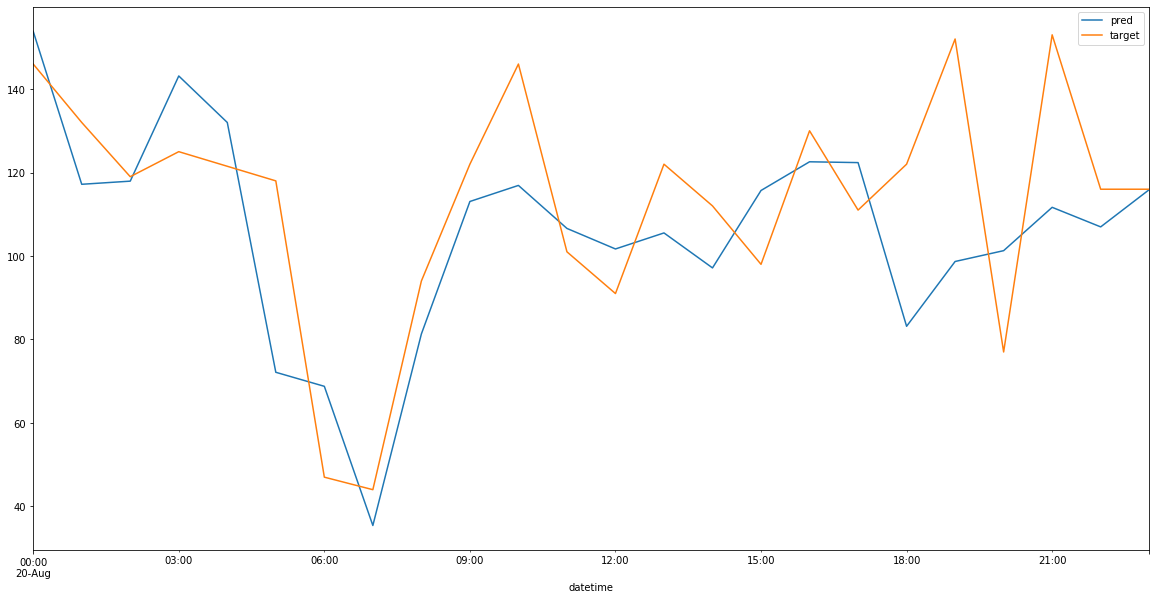

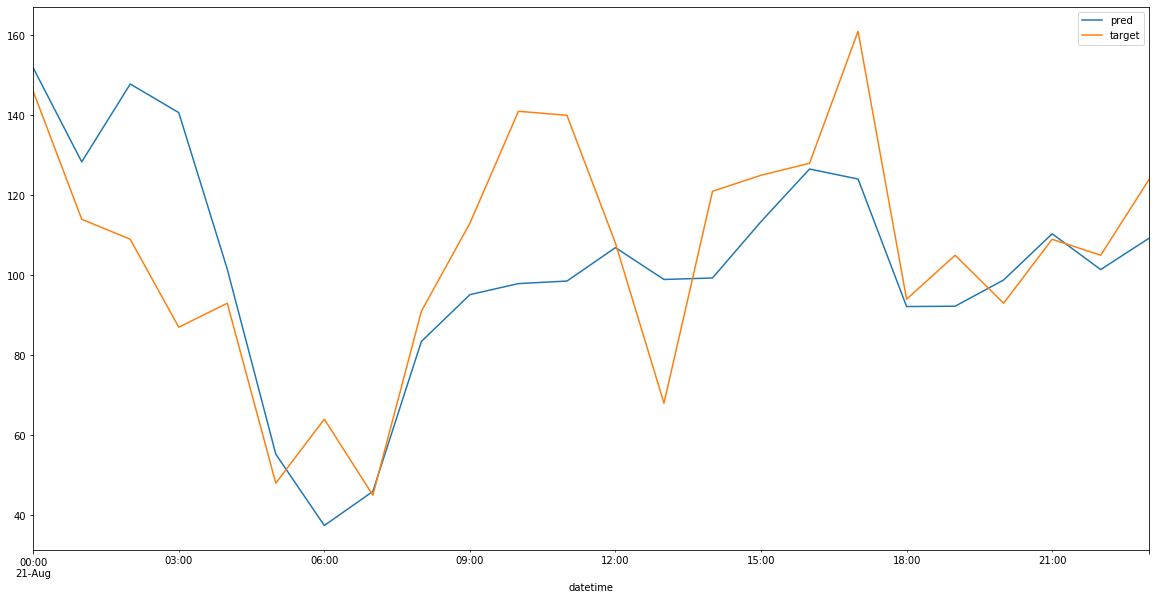

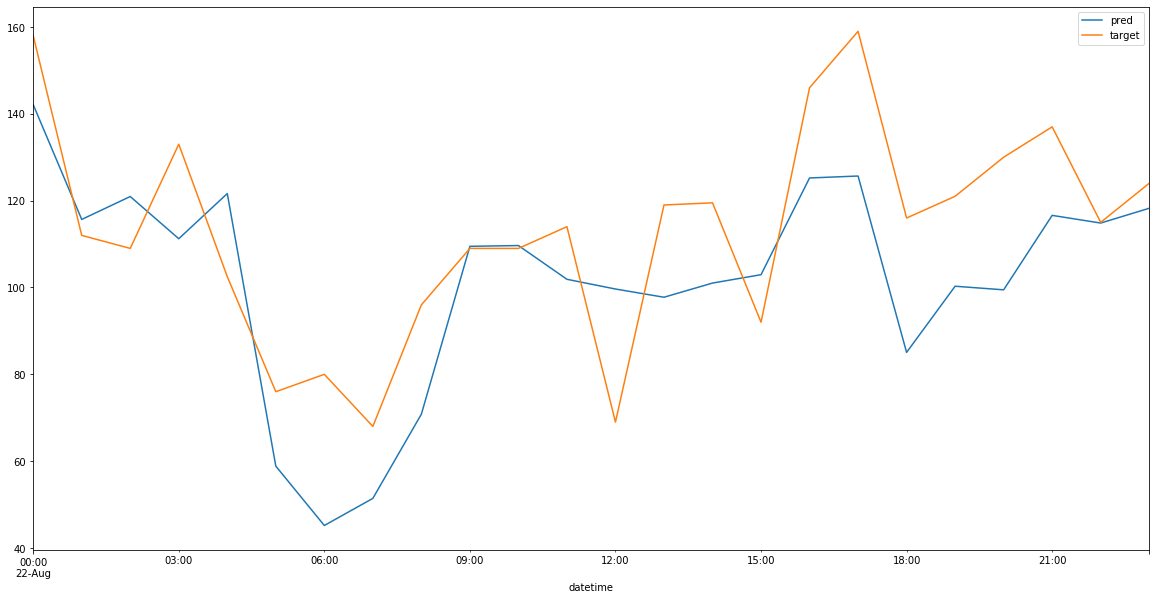

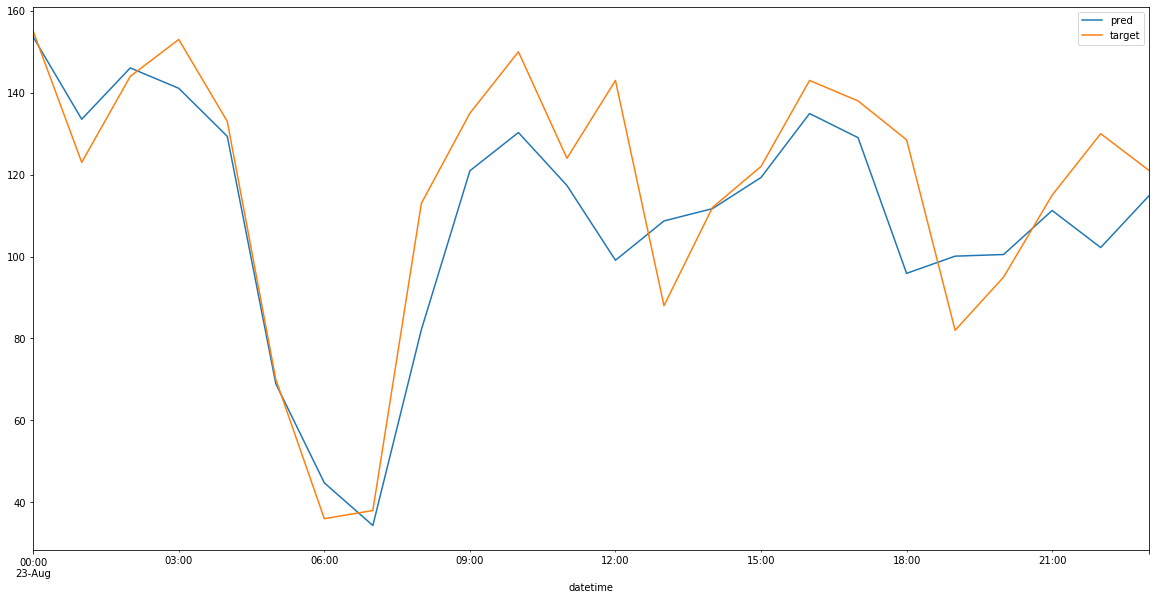

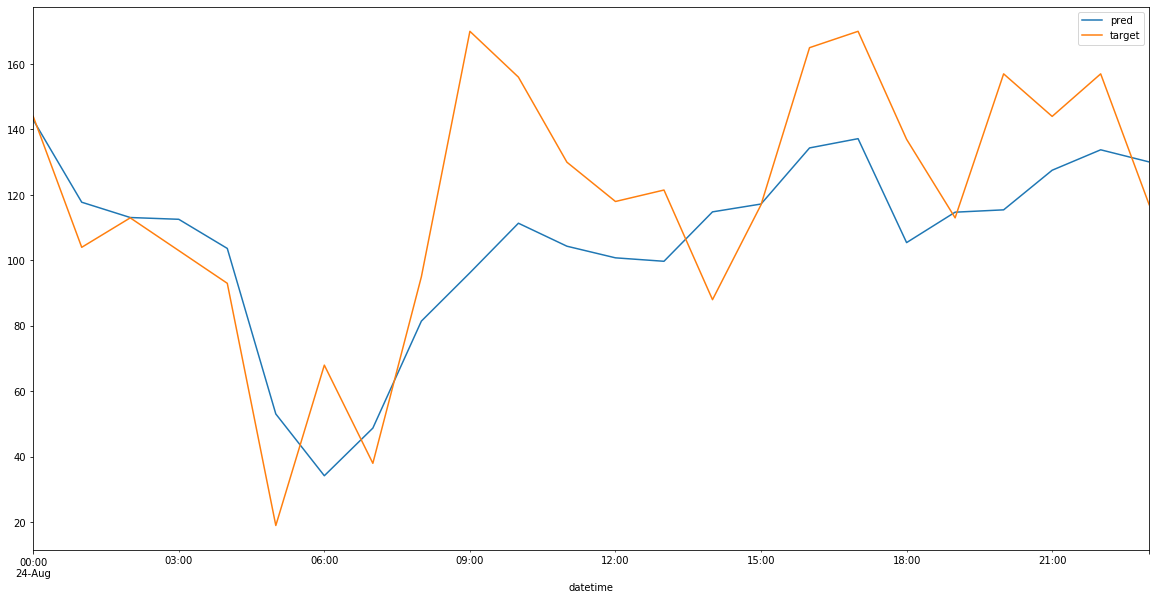

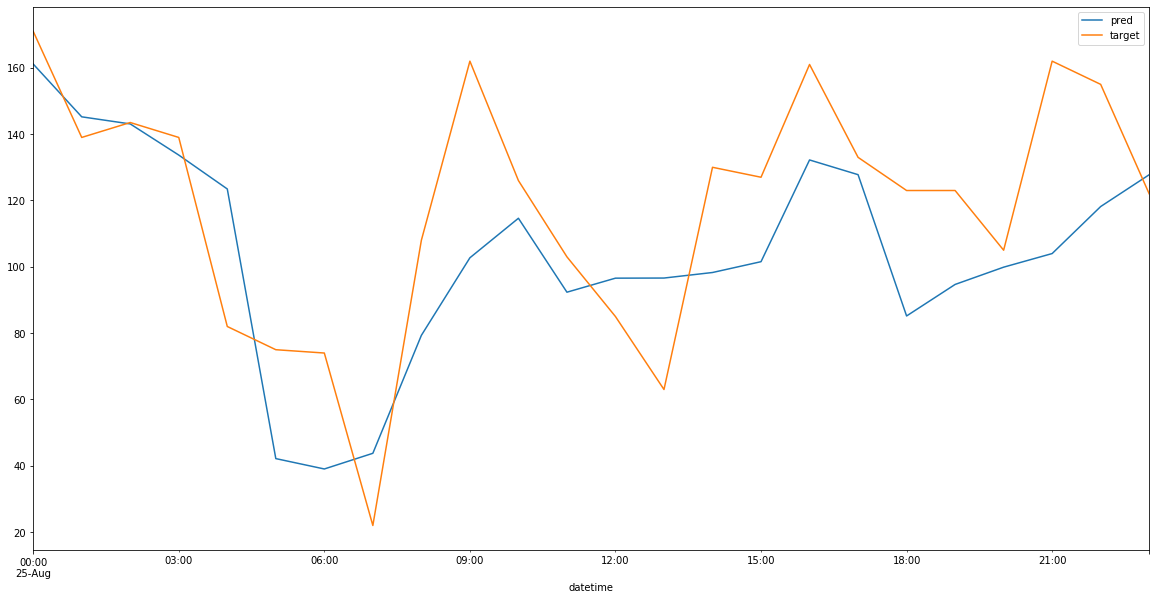

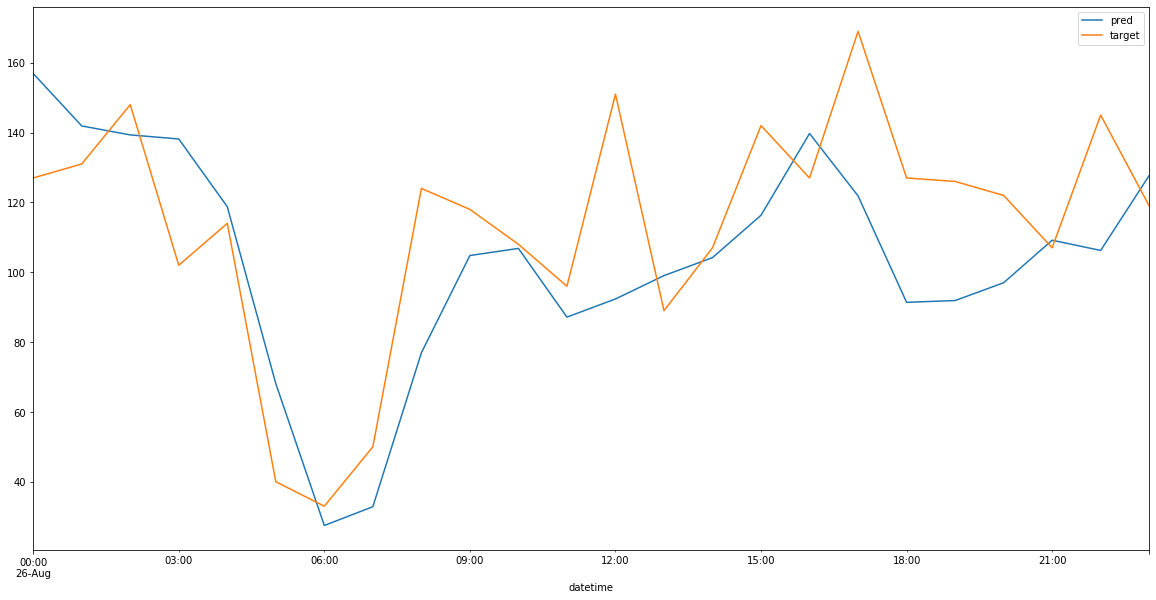

In [69]:
for i in range(20, 27):
    pred_target[f'2018-08-{i}'].plot(figsize=(20, 10))

Из графиков видно, что модель не идеальна, но всёже приблизительные очертания совпадают.

# 5. Вывод.<a id='5_Вывод.'></a>

Проведена предобработка данных.Данные проанализированы, построены графики для построения действий по обучению модели. Было решено добавить признаки временных сдвигов и скользящего среднего для преобразования временного ряда в более стационарный. Лучшие результаты обучненных на тренировочной выборке моделей с наиболее подходящими параметрами по GSCV:  
- RandomForestRegressor  
РМСЕ 21.85833750027443 Самые лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}  
при количестве времсенных сдвигов = 1  
при скользящем среднем с окном = 8  
- CatBoostRegressor  
РМСЕ 22.709751630147853 Самые лучшие параметры модели = {'max_depth': 10, 'n_estimators': 100}  
при количестве времсенных сдвигов = 1  
при скользящем среднем с окном = 8  
- LGBMRegressor  
21.27038396093088 Самые лучшие параметры модели = {'max_depth': 10, 'n_estimators': 75}  
при количестве времсенных сдвигов = 1  
при скользящем среднем с окном = 8  

Наилучший результат показала модель LGBMRegressor. На тестовой выборке результат ухудшился до 31.438495916484552, но всё ещё удовлетваряет, т.к. верхний порог по заданию = 48. Модель подготовлена.  

Из графика сравнения прогноза и факта видно, что чаще всего прогноз ниже факта, что приведёт к убыткам. Скорее всего на рынке начал действовать фактор, которого не было при обучении модели(пример - возвращение с отпусков в августе.) Необходимы дополнительные данные и уточнения у бизнеса.